In [1]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict


# DATA LOAD

In [3]:
mnist_sci = fetch_openml('mnist_784')

In [37]:
x_train, x_test, y_train_, y_test_ = train_test_split(mnist_sci.data, mnist_sci.target, 
                                                    test_size = 0.1,
                                                   shuffle = True)
x_train /= 255.0
x_test /= 255.0
x_train = x_train.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)

def one_hoy_label(X):
    T = np.zeros((X.size, 10))    
    for idx, row in enumerate(T):
        row[int(X[idx])] = 1
        
    return T

y_train = one_hoy_label(y_train_)
y_test = one_hoy_label(y_test_)

In [38]:
class Softmax_CE:
    """
    편의를 위해서 softmax와 crossenropy를 결합한 것입니다.
    """
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = CE_loss(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

## 문제 1 에서 구현한 것을 바탕으로 CNN도 적용됩니다.

In [39]:
class FClayer:
    ######################################################################
    # 문제 1-4 fully connecter layer 를 완성하세요                       #
    # 행렬의 곱셈에 대한 backward를 신중히 구현하세요                    #
    ######################################################################
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        
        self.x = None
        
        # backward 를 위해서 shape을 변경할 수가 있어서 원래의 shape 저장
        self.original_x_shape = None
        
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 본인이 구현한 입력 이미지의 shape 에 따라서 조정을 해줄수도 있습니다.
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1)
        self.x = x
        out = np.dot(self.x,self.W) + self.b
        return out
    
    # 1차원 함수의 곱셈에 대해서 생각해보고 그것을 확장하세요 
    # 항상 데이터의 shape에 주의 하세요
    def backward(self, dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis = 0)
        dx = dx.reshape(*self.original_x_shape)
        return dx
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [40]:
def softmax(x):
    
    ######################################################################
    # 문제 1-1 softmax 함수를 구현하세요                                 #
    ######################################################################
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x,axis = 0)
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T
    x = x-np.max(x)
    return np.exp(x)/np.sum(np.exp(x))
      
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################
    
   

In [41]:
class Relu:
    ######################################################################
    # 문제 1-3 Rely layer 를 구현하세요                                  #
    # 출력값이 0이 되는 부분과 아닌 부분에 대해서 잘 생각해보세요        #
    ######################################################################
    
    # masking을 해보세요
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    # 항등항수의 미분은 자기 자신입니다. 
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout


        return dx
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [42]:
def CE_loss(y, t):
    
    
    ######################################################################
    # 문제 1-2 cross entropy 함수를 구현하세요.                               
    # y 값의 경우 예측한 값, t값의 경우 true label 값입니다.    
    # batch 로 데이터가 들어온다는 것을 유의 하세요.
    ######################################################################
    
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    ce = -np.sum(np.log(y[np.arange(batch_size), t]+ 1e-7)) / batch_size
    
    return ce

    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

---

In [43]:
class Conv():
    def __init__(self, W, b, stride=1, pad=0
    ):
        super().__init__()
        
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.x = None   
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None
        
        self.out_h = None
        self.out_w = None
        
    
    def forward(self, x):
        # backward 의 shape 확인을 위해서 저장
        self.x = x[:]        
        
        FN, C_, FH, FW = self.W.shape
        N, C, H, W = x.shape
        
        # output 출력 shape 
        self.out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        self.out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        out_h = self.out_h
        out_w = self.out_w        
        
        # padding
        pad_x = np.pad(
            x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 
            "constant", constant_values=0
        )
        

        out = np.zeros((N, FN, out_h, out_w))        
        for n in range(N):
            for f in range(FN):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-1-1 forward를 구현 하세요                                   #
                        ######################################################################
                        pos_y = j*self.stride
                        pos_x = i*self.stride
                        out[n,f,j,i] = (np.sum(pad_x[n,:,pos_y:pos_y+FH,pos_x:pos_x+FW]*self.W[f]))+self.b[f]
                                 
                        
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
                        

        return out

    def backward(self, dout):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = self.x.shape
        
        out_h = self.out_h
        out_w = self.out_w
        
        # padding
        pad_x = np.pad(
            self.x, 
            ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), 
            "constant", constant_values=0
        )
        
        dx = np.zeros(pad_x.shape)
        dw = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)
        
    
        for n in range(N):
            for f in range(FN):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-1-2 backward 구현 하세요                                   #
                        ######################################################################
                        pos_y = j*self.stride
                        pos_x = i*self.stride
                           
                        dw[f] +=pad_x[n, :, pos_y:pos_y+FH, pos_x:pos_x+FW] * dout[n, f, j, i]
                        db[f] +=dout[n, f, j, i]
                        dx[n, :, pos_y:pos_y+FH, pos_x:pos_x+FW] += self.W[f] * dout[n, f, j, i]
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################
                        
        # remove padding
        dx = dx[:, :, self.pad:dx.shape[2]-self.pad, self.pad:dx.shape[3]-self.pad]
        
        self.db = db
        self.dW = dw
        
        return dx

In [50]:
class MaxPooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None

    def forward(self, x):
        self.x = x[:]
        N, C, H, W = x.shape
        
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        
        out = np.zeros((N, C, out_h, out_w))
        for j in range(out_h):
            for i in range(out_w):
                ######################################################################
                # 문제 2-2-1 forward를 구현 하세요                                   #
                ######################################################################
                         
                y_pos = j*self.stride
                x_pos = i*self.stride
                
                out[:,:,j,i] = np.max(self.x[:,:,y_pos:y_pos+self.pool_h,x_pos:x_pos+self.pool_w],axis=(2,3))
   
                


                ######################################################################
                #                          END OF YOUR CODE                          #
                ######################################################################
        return out

    def backward(self, dout):
        
        N, C, H, W = self.x.shape
        out_h = (H-self.pool_h) // self.stride + 1
        out_w = (W-self.pool_w) // self.stride + 1

        dx = np.zeros(self.x.shape)
        for n in range(N):
            for c in range(C):
                for j in range(out_h):
                    for i in range(out_w):
                        ######################################################################
                        # 문제 2-2-2 backward를 구현 하세요                                   #
                        ######################################################################

                        y_pos = j*self.stride
                        x_pos = i*self.stride
                        m = np.max(self.x[n,c,y_pos:y_pos+self.pool_h,x_pos:x_pos+self.pool_w])
                        
                        dx[n,c,y_pos:y_pos+self.pool_h,x_pos:x_pos+self.pool_w] = 
                        (self.x[n,c,y_pos:y_pos+self.pool_h,x_pos:x_pos+self.pool_w] == m) * dout[n,c,j,i]
                        
                        ######################################################################
                        #                          END OF YOUR CODE                          #
                        ######################################################################        
        return dx

In [51]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        weight_init_std = 0.01
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = MaxPooling(pool_h=2, pool_w=2, stride=2)
        self.layers['FClayer1'] = FClayer(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['FClayer2'] = FClayer(self.params['W3'], self.params['b3'])

        self.last_layer = Softmax_CE()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        ######################################################################
        #  2-3 해당 주어진 gradient 함수에 주석을 다세요                     #
        ######################################################################
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)# 위에서부터 순전파와 역전파가 반복


        layers = list(self.layers.values())#self.layers.values를 list형태로 변환
        layers.reverse() #리스트의 요소를 뒤집어줌

        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}# 각 layer에서 얻어진 가중치 업데이트
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['FClayer1'].dW, self.layers['FClayer1'].db
        grads['W3'], grads['b3'] = self.layers['FClayer2'].dW, self.layers['FClayer2'].db

        return grads

In [52]:
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 3, 'filter_size': 3, 'pad': 0, 'stride': 1},
                        hidden_size=16, output_size=10)

In [53]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

## 학습이 되기전 conv layer 의 파라미터값

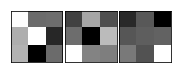

In [54]:
filter_show(network.params['W1'])

In [55]:
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

test_acc_list = []
epochs = 3
step = int(train_size / batch_size)

for epoch in range(epochs):
    for batch_idx in range(step):
        x_batch = x_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        y_batch = y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        grad = network.gradient(x_batch, y_batch)


        # 매개변수 갱신
        for key in network.params.keys():
            network.params[key] -= learning_rate * grad[key]

        # 학습 경과 기록
        loss = network.loss(x_batch, y_batch)

    test_acc = network.accuracy(x_test, y_test)
    print(" test acc | " + str(test_acc))

 test acc | 0.7225714285714285
 test acc | 0.9192857142857143
 test acc | 0.9304285714285714


## 학습 후 파라미터 값

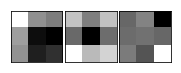

In [56]:
######################################################################
#  2-4 학습된 필터를 캡처하여 제출하세요                                      #
######################################################################
filter_show(network.params['W1'])